## Creating figures summarising the train/evaluation data sets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import time, datetime
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
from torch.utils.data import TensorDataset, DataLoader

path_dict = loadpaths.loadpaths()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
df_pd_outline = lca.load_pols(path_dict['pd_outline'])
df_eval_tiles_outline = lca.load_pols('../content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')

In [11]:
## Save list to file:
# lca.save_tile_names_to_list(list_tile_names=list(df_tiles_eval['PLAN_NO'].unique()), text_filename='content/evaluation_sample_50tiles/evaluation_sample_50tiles_list.txt')
 
no_class_threshold = 1.0
 ## LC polygons:
df_lc_80s, mapping_class_inds = lca.load_landcover(pol_path=path_dict['lc_80s_path'])
df_lc_80s = lca.add_main_category_column(df_lc=df_lc_80s)
# df_lc_2022 = lca.load_pols(pol_path=path_dict['evaluation_50tiles_polygons'])

## Get list of tile names from text file:
list_ds_names = ['eval', 'all']#, 'cde_training']
dict_ds_tile_names_file = {'cde_training': '/home/tplas/repos/cnn-land-cover/content/CDE_training_tiles/CDE_training_tiles.shp',
                           'eval': '/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles_list.txt'}
dict_ds_expected_n_tiles = {'eval': 50}
dict_ds_tile_names = {}
dict_df_tiles = {}
dict_dict_intersect_pols = {}
dict_df_class_distr = {}
for name_ds in list_ds_names:
    print(f'\nNow loading {name_ds} tiles.')

    if name_ds != 'all':
        if dict_ds_tile_names_file[name_ds][-4:] == '.txt':
            ## Load list of tile names:
            with open(dict_ds_tile_names_file[name_ds], 'r') as f:
                tmp = f.readlines()
            dict_ds_tile_names[name_ds] = [x.rstrip('\n') for x in tmp]

            ## Select tiles by name & save as new shp file
            dict_df_tiles[name_ds] = lca.select_tiles_from_list(list_tile_names=dict_ds_tile_names[name_ds], 
                                        save_new_shp=False,
                                        new_shp_filename=dict_ds_tile_names_file[name_ds].rstrip('.txt').rstrip('_list'))

        elif dict_ds_tile_names_file[name_ds][-4:] == '.shp':
            dict_df_tiles[name_ds] = lca.load_pols(dict_ds_tile_names_file[name_ds])
    elif name_ds == 'all':
        dict_df_tiles[name_ds] = lca.get_shp_all_tiles()

    if name_ds in dict_ds_expected_n_tiles.keys():
        assert len(dict_df_tiles[name_ds]) == dict_ds_expected_n_tiles[name_ds], 'Not expected number of tiles. Perhaps this is second pass?'

    dict_dict_intersect_pols[name_ds] = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=dict_df_tiles[name_ds], 
                                                               col_name='PLAN_NO', verbose=0)
    
    ## Calculate distribution of classes for each tile:
    dict_df_class_distr[name_ds] = lca.create_df_with_class_distr_per_tile(dict_dfs=dict_dict_intersect_pols[name_ds], 
                                                         all_class_names=list(df_lc_80s['LC_D_80'].unique()) + ['0'],  # the '0' is for newly added no-class, due to being outside of PD outline (eg outside park)
                                                         no_class_threshold=no_class_threshold)
    dict_df_tiles[name_ds] = dict_df_tiles[name_ds][np.isin(dict_df_tiles[name_ds]['PLAN_NO'], dict_df_class_distr[name_ds]['tile_name'])]
    assert len(dict_df_tiles[name_ds]) == len(dict_df_class_distr[name_ds])

    ## Reorder columns to match order of class names:
    tmp = lca.create_mapping_label_names_to_codes() 
    dict_df_class_distr[name_ds] = dict_df_class_distr[name_ds].reindex(columns=['tile_name'] + list(tmp.keys()))

    ## Get rid of '0' column (because that is area outside park outline):
    dict_df_class_distr[name_ds] = dict_df_class_distr[name_ds].drop(columns=['NO CLASS'])





Now loading eval tiles.


100%|██████████| 50/50 [00:01<00:00, 32.86it/s]
50it [00:00, 266.42it/s]



Now loading all tiles.


100%|██████████| 2125/2125 [00:49<00:00, 43.33it/s] 
2125it [00:07, 268.23it/s]


In [24]:
## Remove columns that are NaN:
dict_df_class_distr['all'] = dict_df_class_distr['all'].dropna(axis=1, how='all')
dict_df_class_distr['eval'] = dict_df_class_distr['eval'].dropna(axis=1, how='all')


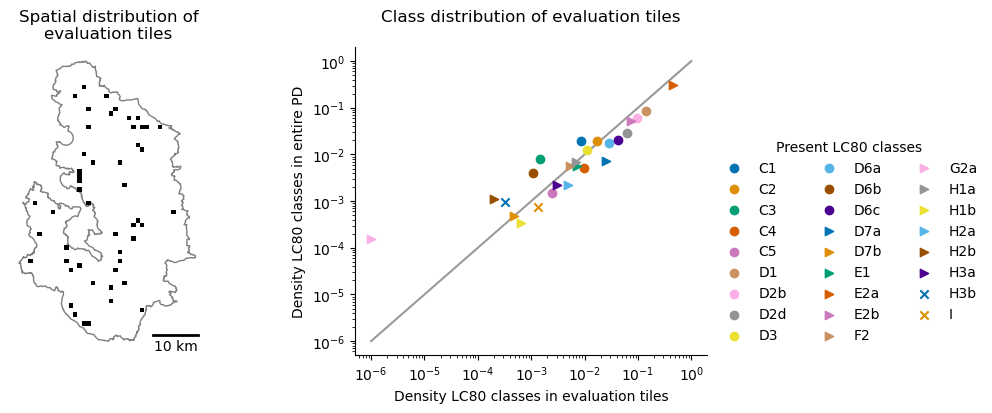

In [44]:
save_fig = True

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
df_pd_outline.plot(ax=ax[0], facecolor='none', edgecolor='grey')#, legend_kwds={'label': 'Peak District'})
df_eval_tiles_outline.plot(ax=ax[0], facecolor='k')#, legend_kwds={'label': 'Evaluation tiles'})
ax[0].axis('off')
# ax[0].legend()
ax[0].set_title('Spatial distribution of\nevaluation tiles')
ax[0].plot([423000, 433000], [350000, 350000], c='k', linewidth=2)
ax[0].text(s='10 km', x=428000, y=349000, ha='center', va='top')

lcv.plot_scatter_class_distr_two_dfs(df_1=dict_df_class_distr['eval'], label_1='Evaluation',
                                     df_2=dict_df_class_distr['all'], label_2='Entire PD',
                                     ax=ax[1], lc_name='LC80',
                                     save_fig=False)
ax[1].set_title('Class distribution of evaluation tiles\n')
ax[1].set_xlabel('Density LC80 classes in evaluation tiles')
ax[1].set_ylabel('Density LC80 classes in entire PD')
ax[1].legend(bbox_to_anchor=(1, 0), ncol=3, title='Present LC80 classes', 
             loc='lower left', frameon=False)
if save_fig:
    plt.savefig(f'../figures/fig_eval_tiles_distr.pdf', bbox_inches='tight')